In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
train = pd.read_csv('../input/metadata_train.csv')
test = pd.read_csv('../input/metadata_test.csv')

In [4]:
train.head()

signal_id  id_measurement  phase  target
0          0               0      0       0
1          1               0      1       0
2          2               0      2       0
3          3               1      0       1
4          4               1      1       1

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 4 columns):
signal_id         8712 non-null int64
id_measurement    8712 non-null int64
phase             8712 non-null int64
target            8712 non-null int64
dtypes: int64(4)
memory usage: 272.3 KB


In [7]:
train.describe()

signal_id  id_measurement        phase       target
count  8712.000000     8712.000000  8712.000000  8712.000000
mean   4355.500000     1451.500000     1.000000     0.060262
std    2515.082106      838.360658     0.816543     0.237985
min       0.000000        0.000000     0.000000     0.000000
25%    2177.750000      725.750000     0.000000     0.000000
50%    4355.500000     1451.500000     1.000000     0.000000
75%    6533.250000     2177.250000     2.000000     0.000000
max    8711.000000     2903.000000     2.000000     1.000000

In [8]:
train.groupby('id_measurement')['target'].mean()

id_measurement
0       0.000000
1       1.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47      0.000000
48      0.000000
49      0.000000
50      0.000000
51      0.000000
52      0.000000
53      0.000000
54      0.000000
55      0.000000
56      0.000000
57      0.000000

In [9]:
train['target'].value_counts()

0    8187
1     525
Name: target, dtype: int64

In [15]:
train[train['target']==1]['target'].count()*100 / train['target'].count()

6.026170798898072

In [18]:
train_pq = pd.read_parquet('../input/train.parquet', engine='pyarrow')

In [19]:
train_pq.head()

0  1   2   3  4   5   6   7  8   9  10  11  12  13  14  15  16  17  18  \
0  18  1 -19 -16 -5  19 -15  15 -1 -16  -9  23  -1 -17  16  -8  17 -10  21   
1  18  0 -19 -17 -6  19 -17  16  0 -15 -10  22   0 -16  17  -7  17 -10  20   
2  17 -1 -20 -17 -6  19 -17  15 -3 -15 -10  22  -1 -16  17  -9  16 -11  20   
3  18  1 -19 -16 -5  20 -16  16  0 -15  -9  22  -1 -17  17  -7  18  -9  21   
4  18  0 -19 -16 -5  20 -17  16 -2 -14  -8  24  -2 -17  16  -9  16 -11  20   

   19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  \
0  -8 -12  -7  23 -15 -20  13   4 -20   1  15  13  -2 -17   5  16 -20   9 -16   
1  -9 -12  -7  24 -14 -20  14   4 -20   1  15  14  -3 -18   5  16 -20   9 -15   
2  -8 -12  -6  24 -14 -20  13   4 -20   1  15  11  -3 -18   5  16 -20   8 -16   
3  -8 -12  -5  25 -14 -21  14   4 -20   1  15  14  -3 -17   5  16 -20   8 -16   
4  -8 -13  -6  24 -13 -21  14   4 -20   1  15  14  -3 -18   4  16 -21   8 -16   

   38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  \
0   7  10 -17   5 -16  18   0  -8  17 -13  -6  18 -17  16   4 -19 -18  -3  21   
1   7   9 -18   5 -17  18   0 -10  15 -14  -5  19 -16  16   5 -19 -18  -4  21   
2   7  10 -17   6 -18  18  -1  -9  15 -14  -5  19 -16  17   4 -19 -18  -3  21   
3   7  10 -18   5 -18  15  -1  -9  16 -13  -4  19 -15  16   4 -20 -19  -4  20   
4   7  10 -18   5 -17  15  -2  -7  18 -12  -4  20 -15  16   4 -20 -18  -3  20   

   57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
0 -19  14   3  -3 -18  18  -4  22 -19 -16  14  -6   3  12 -18 -16  19 -10  13   
1 -21  14   3  -5 -18  20  -6  20 -21 -10  21   1   4  13 -17 -14  20  -8   9   
2 -20  14   1  -4 -18  17  -7  20 -21 -18  12  -6   5  13 -17 -15  21  -8  11   
3 -19  15   3  -4 -18  19  -6  21 -19 -15  15  -6   2  11 -18 -16  19  -9  12   
4 -20  14   2  -4 -18  19  -4  23 -18 -12  19   0   5  14 -17 -17  17 -11  12   

   76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  \
0 -21   5  11  15 -24  13   9 -25 -18  -7  23  12   6 -18  15   1 -18  10   7   
1 -21   5  11  15 -23  15   9 -24 -17  -7  24  12   5 -18  15   2 -18  11   8   
2 -21   7  11  15 -23  15  10 -24 -17  -7  23  11   5 -20  16   3 -17  10   7   
3 -19   6  11  15 -24  15  10 -23 -17  -7  23  11   4 -20  16   3 -17   9   7   
4 -19   8  11  14 -25  13   9 -24 -17  -7  23  11   3 -21  15   1 -18  10   7   

   95  96  97  98  99  ...   8612  8613  8614  8615  8616  8617  8618  8619  \
0 -18  19 -17  -1  21  ...     -7    19    -8   -16    12   -26    13   -14   
1 -17  18 -18   0  19  ...     -8    20    -8   -13    11   -26    12   -14   
2 -18  20 -18  -1  19  ...    -10    19   -10   -15    10   -26    11   -14   
3 -19  19 -17  -1  21  ...     -8    19    -8   -14    10   -27    10   -15   
4 -18  19 -18  -1  20  ...     -7    20    -9   -14    10   -27    10   -14   

   8620  8621  8622  8623  8624  8625  8626  8627  8628  8629  8630  8631  \
0    -6    15    11     3   -20    -9    -8    25    17    -8   -10    20   
1    -5    15    11     4   -18    -9    -8    24    15   -10   -14    12   
2    -5    14    13     5   -18    -9    -8    25    21    -4    -7    16   
3    -7    14    12     6   -18    -9    -9    24    15   -11   -15    16   
4    -6    14    13     5   -18    -9    -9    24    16    -8   -10    13   

   8632  8633  8634  8635  8636  8637  8638  8639  8640  8641  8642  8643  \
0   -15     1    -9   -16    17     8   -20    11    12   -22    15    19   
1   -18     0    -8   -15    17     9   -19    12    12   -21    14    20   
2   -15     2    -6   -13    19     8   -20    12    12   -22    15    19   
3   -19    -1    -6   -13    20     7   -21    10    12   -22    15    20   
4   -16     2    -6   -12    20     8   -21    11    12   -22    14    20   

   8644  8645  8646  8647  8648  8649  8650  8651  8652  8653  8654  8655  \
0   -16    -8    -8    19   -12   -20     8     9    12     2   -19   -14   
1   -17    -8    -9    19   -12 

In [20]:
train_pq.shape

(800000, 8712)

In [22]:
train_pq.transpose()

0       1       2       3       4       5       6       7       8       \
0         18      18      17      18      18      18      19      18      18   
1          1       0      -1       1       0       0       1       0       0   
2        -19     -19     -20     -19     -19     -20     -18     -19     -20   
3        -16     -17     -17     -16     -16     -15     -16     -17     -18   
4         -5      -6      -6      -5      -5      -4      -5      -7      -7   
5         19      19      19      20      20      20      20      18      18   
6        -15     -17     -17     -16     -17     -16     -16     -17     -16   
7         15      16      15      16      16      15      16      15      15   
8         -1       0      -3       0      -2      -2      -1      -2      -2   
9        -16     -15     -15     -15     -14     -12     -13     -15     -16   
10        -9     -10     -10      -9      -8      -7      -7      -9      -9   
11        23      22      22      22      24      25      26      23      23   
12        -1       0      -1      -1      -2      -1       0       1       0   
13       -17     -16     -16     -17     -17     -17     -16     -16     -16   
14        16      17      17      17      16      16      17      18      17   
15        -8      -7      -9      -7      -9      -8      -7      -9      -8   
16        17      17      16      18      16      18      18      16      18   
17       -10     -10     -11      -9     -11     -10      -9     -11     -10   
18        21      20      20      21      20      21      21      20      20   
19        -8      -9      -8      -8      -8      -8      -8      -9      -8   
20       -12     -12     -12     -12     -13     -13     -11     -14     -12   
21        -7      -7      -6      -5      -6      -5      -6      -6      -7   
22        23      24      24      25      24      25      24      23      23   
23       -15     -14     -14     -14     -13     -13     -14     -15     -15   
24       -20     -20     -20     -21     -21     -21     -20     -20     -21   
25        13      14      13      14      14      14      14      14      13   
26         4       4       4       4       4       5       5       4       4   
27       -20     -20     -20     -20     -20     -20     -20     -19     -19   
28         1       1       1       1       1       1       1       2       2   
29        15      15      15      15      15      15      14      16      16   
30        13      14      11      14      14      12      13      13      12   
31        -2      -3      -3      -3      -3      -3      -3      -3      -3   
32       -17     -18     -18     -17     -18     -17     -18     -18     -17   
33         5       5       5       5       4       4       4       3       3   
34        16      16      16      16      16      15      15      15      15   
35       -20     -20     -20     -20     -21     -21     -21     -22     -22   
36         9       9       8       8       8       9       9       9       9   
37       -16     -15     -16     -16     -16     -16     -15     -16     -16   
38         7       7       7       7       7       6       7       7       7   
39        10       9      10      10      10      11      10       9       9   
40       -17     -18     -17     -18     -18     -17     -17     -18     -18   
41         5       5       6       5       5       6       6       5       5   
42       -16     -17     -18     -18     -17     -17     -17     -17     -18   
43        18      18      18      15      15      17      17      18      16   
44         0       0      -1      -1      -2       0       0      -1      -2   
45        -8     -10      -9      -9      -7      -7      -8      -7      -9   
46        17      15      15      16      18      17      17      16      16   
47       -13     -14     -14     -13     -12     -13     -12     -13     -13   
48        -6      -5      -5      -4      -4      -4      -5      -6      -7   
49    

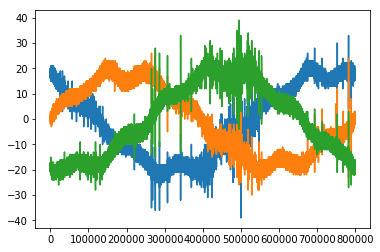

In [37]:
plt.plot(train_pq['0'])
plt.plot(train_pq['1'])
plt.plot(train_pq['2'])

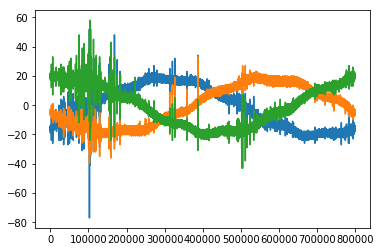

In [38]:
plt.plot(train_pq['3'])
plt.plot(train_pq['4'])
plt.plot(train_pq['5'])

In [27]:
train.head()

signal_id  id_measurement  phase  target
0          0               0      0       0
1          1               0      1       0
2          2               0      2       0
3          3               1      0       1
4          4               1      1       1

In [35]:
test.shape

(20337, 3)

In [36]:
test.head()

signal_id  id_measurement  phase
0       8712            2904      0
1       8713            2904      1
2       8714            2904      2
3       8715            2905      0
4       8716            2905      1

In [41]:
train[train['target']==1]

signal_id  id_measurement  phase  target
3             3               1      0       1
4             4               1      1       1
5             5               1      2       1
201         201              67      0       1
202         202              67      1       1
228         228              76      0       1
229         229              76      1       1
230         230              76      2       1
270         270              90      0       1
271         271              90      1       1
272         272              90      2       1
279         279              93      0       1
280         280              93      1       1
281         281              93      2       1
285         285              95      0       1
286         286              95      1       1
287         287              95      2       1
290         290              96      2       1
294         294              98      0       1
295         295              98      1       1
296         296              98      2       1
380         380             126      2       1
408         408             136      0       1
409         409             136      1       1
410         410             136      2       1
432         432             144      0       1
433         433             144      1       1
434         434             144      2       1
435         435             145      0       1
436         436             145      1       1
437         437             145      2       1
456         456             152      0       1
457         457             152      1       1
458         458             152      2       1
479         479             159      2       1
516         516             172      0       1
517         517             172      1       1
518         518             172      2       1
570         570             190      0       1
571         571             190      1       1
572         572             190      2       1
678         678             226      0       1
679         679             226      1       1
680         680             226      2       1
699         699             233      0       1
700         700             233      1       1
701         701             233      2       1
705         705             235      0       1
706         706             235      1       1
707         707             235      2       1
708         708             236      0       1
709         709             236      1       1
710         710             236      2       1
813         813             271      0       1
876         876             292      0       1
877         877             292      1       1
878         878             292      2       1
903         903             301      0       1
912         912             304      0       1
913         913             304      1       1
914         914             304      2       1
939         939             313      0       1
940         940             313      1       1
941         941             313      2       1
1002       1002             334      0       1
1003       1003             334      1       1
1004       1004             334      2       1
1017       1017             339      0       1
1018       1018             339      1       1
1019       1019             339      2       1
1026       1026             342      0       1
1027       1027             342      1       1
1028       1028             342      2       1
1032       1032             344      0       1
1033       1033             344      1       1
1034       1034             344      2       1
1050       1050             350      0       1
1051       1051             350      1       1
1052       1052             350      2       1
1074       1074             358      0       1
1075       1075             358      1       1
1076       1076             358      2       1
1083       1083             361      0       1
1084       1084             361      1       1
1085       

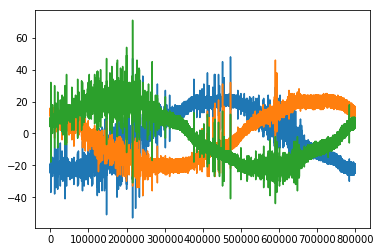

In [45]:
plt.plot(train_pq['201'])
plt.plot(train_pq['202'])
plt.plot(train_pq['203'])

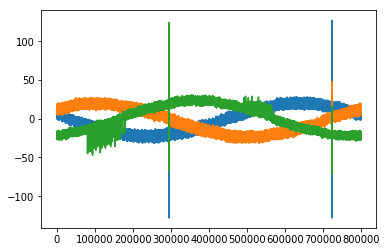

In [46]:
plt.plot(train_pq['228'])
plt.plot(train_pq['229'])
plt.plot(train_pq['230'])

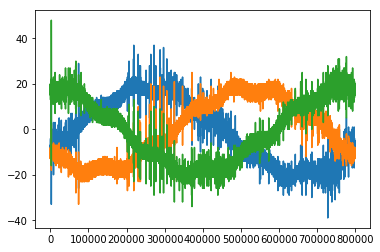

In [47]:
plt.plot(train_pq['270'])
plt.plot(train_pq['271'])
plt.plot(train_pq['272'])

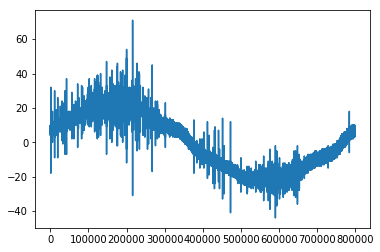

In [44]:
plt.plot(train_pq['203'])